In [1]:
from math import pi
import numpy as np
import scipy as sp
import scipy.linalg as spl
import numpy.linalg as npl
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.sparse.linalg as sspl
from tqdm import tqdm

In [2]:
def A(dz,N):
    N = N-2
    tmp = np.ones((N-1))
    diag = -2*np.ones(N)
    diag[0] /= 2
    diag[-1] /= 2
    return sps.diags((tmp,diag,tmp),(-1,0,1)) * sigma**2 /(dz**2)

def source(Z):
    return (.5 / (2 * pi * sigma**2)**.5) * np.exp(-0.5*((Z-5.0)**2)/sigma**2)

def get_r(Z,rmax,s,theta):
    return rmax - s*(Z-theta)**2

def get_rho(dz,U):
    return dz*(U[0]/2 + U[-1]/2 + np.sum(U[1:-1]))



def solve_explicit(A,U,Z,rho, dz,dt):
    r = get_r(Z, r_max, s, theta)
    tmp1 = sps.eye(A.shape[0])
    tmp2 = dt*A
    tmp3 = (dt*(r-kappa*rho))[1:-1]
    U_next = (tmp1 + tmp2).dot(U) + (U * tmp3)
    return U_next

def solve_implicite(A, U, F, dz, dt):
    
    lhs = (np.eye(A.shape[0]) - dt*A)
    rhs = U + dt*F
    return sspl.cg(lhs, rhs)[0]

def solve_implicite_stat(A, U, F, dz, dt):
    
    tmpl_2 = dt * A
    
    tmpr_2 = dt * (r - kappa * rho)[1:-1]
    
    TMPR = tmpr_2 * U
#     print((tmpl_1 - tmpl_2).shape, TMPR.shape)
    
    return sspl.cg(- tmpl_2, TMPR)[0]

def F(U, r, rho):
    return U * (r - kappa * rho)

def solve_splitting(A, U, Z, dz, dt, theta):

    tempU1 = sspl.cg(np.eye(A.shape[0]) - dt/2 * A, U)[0]
    r = get_r(Z, r_max, s, theta)
    rho = get_rho(dz,U)
    
    tempU2 = tempU1 + dt * F(tempU1, r, rho)
    return sspl.cg(np.eye(A.shape[0]) - dt/2 * A, tempU2)[0]

In [3]:
kappa = 1
s = 1
r_max = 1
sigma = 0.5
theta = 4.5
N = 100
a = 0
b = 10

# Explicit

100%|██████████| 2501/2501 [00:01<00:00, 1388.87it/s]


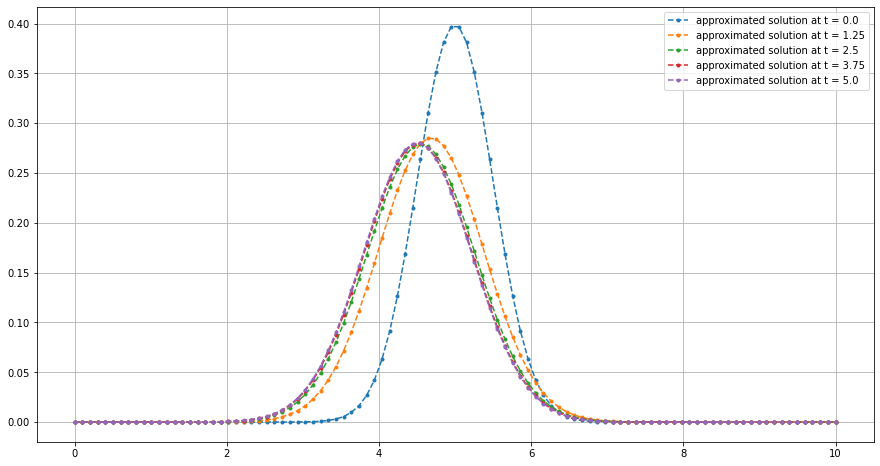

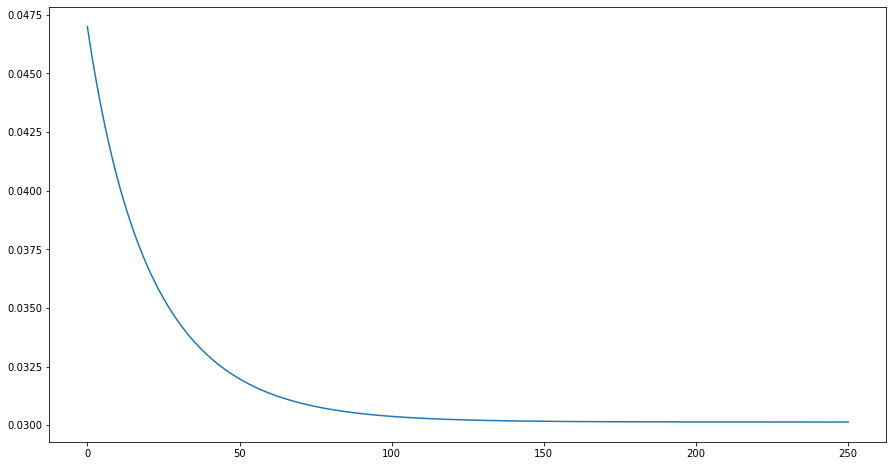

In [4]:
dz = (b-a)/N
dt = 0.002
T = 5
nbT = int(T/dt)
fig = plt.figure(figsize = (15,8))
Z = np.linspace(a,b,N)
U = np.zeros(N)
U[1:-1] = np.copy(source(Z[1:-1]))
U[0] = U[1]
U[-1] = U[-2]
RHO = []
VAR = []
for i in tqdm(range(0, nbT+1)):
    rho = get_rho(dz,U)
    if i % (nbT//4) == 0:
        plt.plot(Z,U, ".--", label = "approximated solution at t = {0}".format(i*dt))
    if i % 10 == 0:
        RHO.append(rho)
        VAR.append(np.var(U/rho))
    U[1:-1] = np.copy(solve_explicit(A(dz,N),U[1:-1],Z,rho, dz,dt))
    U[0] = U[1]
    U[-1] = U[-2]
    
plt.legend()
plt.grid()
plt.show()

fig = plt.figure(figsize = (15,8))
# plt.plot(RHO)
plt.plot(VAR)
plt.show()

# Implicit

100%|██████████| 2501/2501 [00:01<00:00, 1676.76it/s]


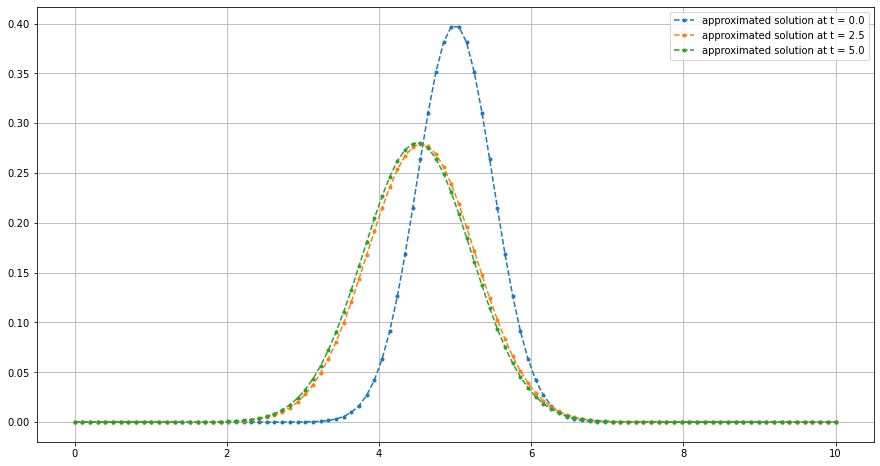

In [5]:

dz = (b-a)/N
dt = 0.002
T = 5
nbT = int(T/dt)
fig = plt.figure(figsize = (15,8))
Z = np.linspace(a,b,N)
U = np.zeros(N)
U[1:-1] = np.copy(source(Z[1:-1]))
U[0] = U[1]
U[-1] = U[-2]

for i in tqdm(range(0, nbT+1)):
    if i % (nbT//2) == 0:
        plt.plot(Z,U, ".--", label = "approximated solution at t = {0}".format(i*dt))
    r = get_r(Z[1:-1], r_max, s, theta)
    rho = get_rho(dz,U[1:-1])
    FU = F(U[1:-1],r,rho)
    U[1:-1] = np.copy(solve_implicite(A(dz,N),U[1:-1],FU,dz,dt))
    U[0] = U[1]
    U[-1] = U[-2]
plt.legend()
plt.grid()
plt.show()


# Time splitting

100%|██████████| 251/251 [00:00<00:00, 788.31it/s]


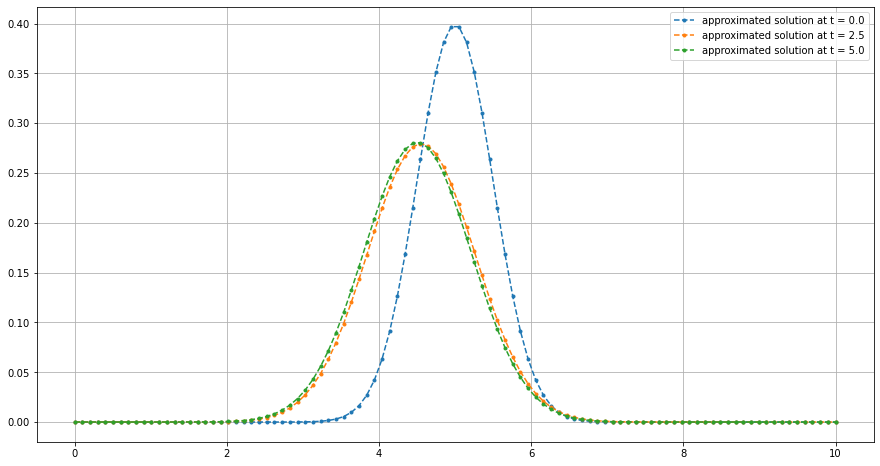

In [7]:
N = 100
a = 0
b = 10
dz = (b-a)/N
dt = 0.02
T = 5
nbT = int(T/dt)
fig = plt.figure(figsize = (15,8))
Z = np.linspace(a,b,N)
U = np.zeros(N)
U[1:-1] = np.copy(source(Z[1:-1]))
U[0] = U[1]
U[-1] = U[-2]
for i in tqdm(range(0, nbT+1)):
    if i % (nbT//2) == 0:
        plt.plot(Z,U, ".--", label = "approximated solution at t = {0}".format(i*dt))
    U[1:-1] = np.copy(solve_splitting(A(dz,N),U[1:-1],Z[1:-1],dz,dt, theta))
    U[0] = U[1]
    U[-1] = U[-2]
plt.legend()
plt.grid()
plt.show()

# Theta with noise

100%|██████████| 1001/1001 [00:01<00:00, 912.30it/s]


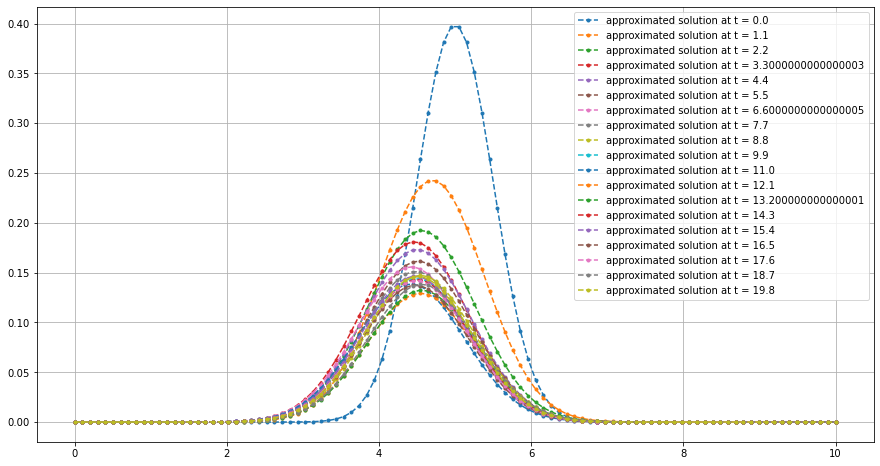

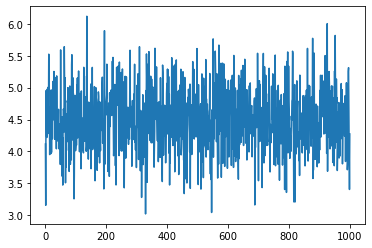

In [8]:

N = 100
a = 0
b = 10
dz = (b-a)/N
dt = 0.02
T = 20
nbT = int(T/dt)
fig = plt.figure(figsize = (15,8))
Z = np.linspace(a,b,N)
U = np.zeros(N)
U[1:-1] = np.copy(source(Z[1:-1]))
U[0] = U[1]
U[-1] = U[-2]
m = 0
std = 0.5
Theta = np.random.normal(theta + m, std,nbT+1)
for i in tqdm(range(0, nbT+1)):
    if i % (nbT//18) == 0:
        plt.plot(Z,U, ".--", label = "approximated solution at t = {0}".format(i*dt))
    U[1:-1] = np.copy(solve_splitting(A(dz,N),U[1:-1],Z[1:-1],dz,dt, Theta[i]))
    U[0] = U[1]
    U[-1] = U[-2]
plt.legend()
plt.grid()
plt.show()
plt.plot(Theta)